# Introduction

Computer Vision, image processing/analysis and pattern recognition has found its way into Medical Image analysis. The goal of Machine Learning is to assist Doctors and healthcare providers to make better and efficient decisions by prioritizing high risk patients.

In this notebook we use the Chest X-Ray Images (Pneumonia) https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
dataset to build a Deep Learning Model to predict if an X-Ray image shows the presence of Pneumonia or not. We will build a Convolution Neural Network to train and predict the results. We will also use Data Augmentation techniques to increase the size of out training set.  

In this tutorial we run the code using GPU as Kaggle provides free access to NVidia K80 GPUs in kernels. We will use the ImageDataGenerator provided by the Keras deep learning library class to perform data augmentation and load the data efficiently for training and validating our model.

### Importing relevant libraries and packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Tensorflow version 2.3.0


Detect my accelerator

## 1. Loading the data and visualize the X-Rays

In the dataset the validation dataset folder contains only 16 images so we will use the test set as validation and the validation folder for final prediction

In [2]:
os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray')

['__MACOSX', 'chest_xray', 'val', 'test', 'train']

In [3]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')
validation_dir = os.path.join(base_dir, 'test')

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

Let's take a look at the first 5 files in the train folder for 'NORMAL' and 'PNEUMONIA' x-rays

In [4]:
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

print(train_normal_fnames[:5])
print(train_pneumonia_fnames[:5])

['IM-0164-0001.jpeg', 'NORMAL2-IM-1153-0001.jpeg', 'IM-0531-0001.jpeg', 'NORMAL2-IM-0866-0001.jpeg', 'IM-0428-0001.jpeg']
['person1306_bacteria_3277.jpeg', 'person578_bacteria_2379.jpeg', 'person328_bacteria_1511.jpeg', 'person261_bacteria_1225.jpeg', 'person1413_virus_2422.jpeg']


In [5]:
print('total training normal images :', len(os.listdir(train_normal_dir) ))
print('total training pneumonia images :', len(os.listdir(train_pneumonia_dir) ))

print('total validation normal images :', len(os.listdir(validation_normal_dir) ))
print('total validation pneumonia images :', len(os.listdir(validation_pneumonia_dir) ))

print('total test normal images :', len(os.listdir(test_normal_dir) ))
print('total test pneumonia images :', len(os.listdir(test_pneumonia_dir) ))

total training normal images : 1341
total training pneumonia images : 3875
total validation normal images : 234
total validation pneumonia images : 390
total test normal images : 8
total test pneumonia images : 8


As we can see that there is data imbalance as there are a lot more of images that are classified as pneumonia than normal. Later in this notebook we will fix this.

Let's take a look at some of the X-Ray images belonging to both the classes

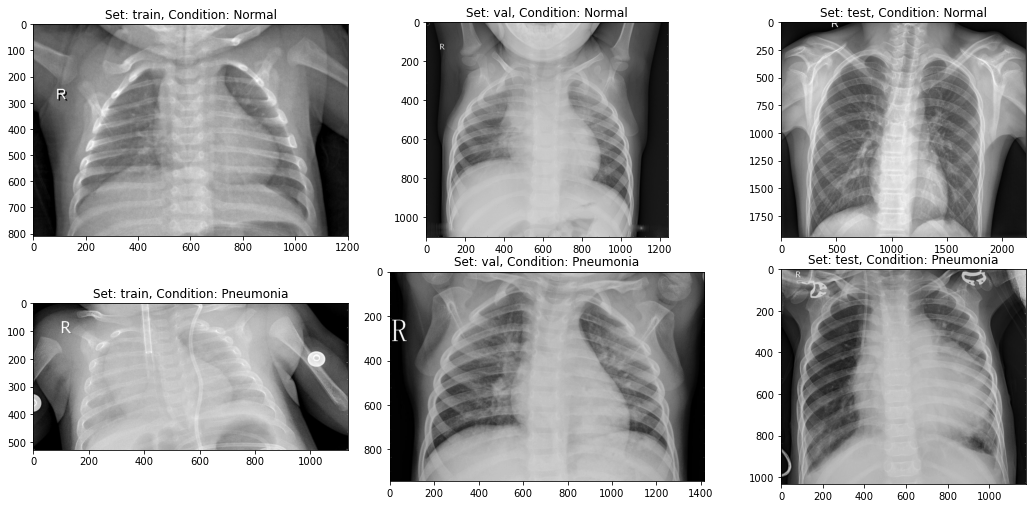

In [6]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = base_dir+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

## 2. Take care of the data imbalance and defining some constant values
We can use the follwoing numbers to assign weights to each of the class to fix the data imbalance issue.

In [7]:
train_normal_count = len(os.listdir(train_normal_dir))
train_pneumonia_count = len(os.listdir(train_pneumonia_dir))
total_train_count = train_normal_count + train_pneumonia_count

val_normal_count = len(os.listdir(validation_normal_dir))
val_pneumonia_count = len(os.listdir(validation_pneumonia_dir))
total_val_count = val_normal_count + val_pneumonia_count

In [8]:
weight_for_normal_0 = (1 / train_normal_count)*(total_train_count)/2.0 
weight_for_pneumonia_1 = (1 / train_pneumonia_count)*(total_train_count)/2.0

class_weight = {0: weight_for_normal_0, 1: weight_for_pneumonia_1}

print(f'Weight for class 0: {class_weight[0]}')
print(f'Weight for class 1: {class_weight[1]}')

Weight for class 0: 1.9448173005219984
Weight for class 1: 0.6730322580645162


In [9]:
image_shape = [150, 150]
batch_size = 64
epochs = 30

## 3. CNN Model Building

Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [10]:
model = tf.keras.models.Sequential([
    
    # The first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'),
    
    # The second convolution    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'),

    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'),

    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'),

    # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'),


    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        3

## 4. Data Preprocessing

Next we set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 150x150 and their labels (binary).

We will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range). We will perform some data augmentation for the training set like shifting the image horizontally and vertically and also zooming in or out by a certain amount.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit, evaluate_generator, and predict_generator.

In [12]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.3,
                                  )

validation_datagen  = ImageDataGenerator(rescale = 1.0/255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    target_size=(image_shape[0], image_shape[1]),
                                                    shuffle=True
                                                   )     

# Flow validation images in batches using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                               batch_size=batch_size,
                                                               class_mode  = 'binary',
                                                               target_size = (image_shape[0], image_shape[1]), 
                                                               shuffle=True
                                                              )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 5. Training the model

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the RMSprop optimizer. During training, we will want to monitor classification accuracy, recall, precision and loss.

NOTE: In this case, using the adam or RMSprop or Adagrad optimization algorithm is preferable to stochastic gradient descent (SGD), because adam and RMSprop automates learning-rate tuning for us.

We will use Keras callbacks to improve our model. 

ModelCheckpoint() callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. ReduceLROnPlateau() callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

EarlyStopping() stops the training when a monitored metric has stopped improving, the model starts to get stagnant or starts to overfit.

In [13]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
          ]

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = metrics
                 )

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_recall',
                                                               patience = 3,
                                                               verbose=1,
                                                               factor=0.2,
                                                               min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(patience=10,
                                              restore_best_weights=True,
                                              verbose=1)

In [14]:
history = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=total_train_count//batch_size,
                        epochs=epochs,
                        validation_steps=total_val_count//batch_size,
                        class_weight=class_weight,
                        verbose=2,
                        callbacks=[learning_rate_reduction, early_stop]
                       )

Epoch 1/30
81/81 - 237s - loss: 0.9507 - accuracy: 0.7964 - precision: 0.9281 - recall: 0.7866 - val_loss: 13.1371 - val_accuracy: 0.6337 - val_precision: 0.6337 - val_recall: 1.0000
Epoch 2/30
81/81 - 221s - loss: 0.3479 - accuracy: 0.8634 - precision: 0.9614 - recall: 0.8505 - val_loss: 26.4075 - val_accuracy: 0.6302 - val_precision: 0.6302 - val_recall: 1.0000
Epoch 3/30
81/81 - 220s - loss: 0.3029 - accuracy: 0.8777 - precision: 0.9657 - recall: 0.8665 - val_loss: 40.0639 - val_accuracy: 0.6302 - val_precision: 0.6302 - val_recall: 1.0000
Epoch 4/30

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
81/81 - 229s - loss: 0.2601 - accuracy: 0.8919 - precision: 0.9706 - recall: 0.8811 - val_loss: 26.7833 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/30
81/81 - 220s - loss: 0.1716 - accuracy: 0.9317 - precision: 0.9812 - recall: 0.9258 - val_loss: 27.2527 - val_accuracy: 0.6181 - val_precision: 0.6181 - val_recall: 1.0000
Epo

## 6. Visualizing model performance

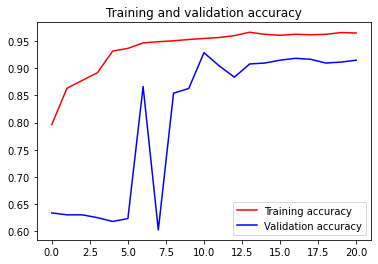

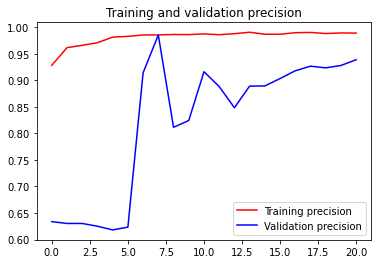

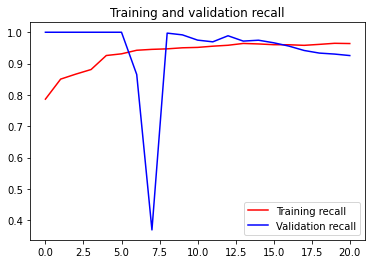

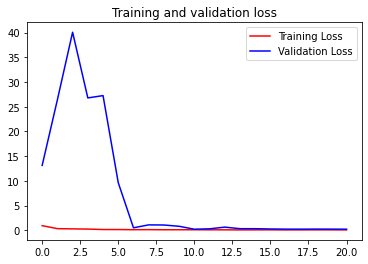

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model is converging which can be seen from the above plots. 

## Model prediction and evaluation on unseen data

Note that we used the original 'test' set for validation and we will use the original 'val' set containing 16 images for testing our model.

In [16]:
# To get the data and labels to make prediction on the test set which contains 16 files which the model has not seen before
import cv2
test_data = []
true_test_labels = []

for item in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(base_dir + 'val' + item)):
        img = plt.imread(base_dir+'val'+item+img)
        img = cv2.resize(img, (image_shape[0], image_shape[1]))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255.
        if item=='/NORMAL/':
            label = 0
        elif item=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        true_test_labels.append(label)
        
test_data = np.array(test_data)
true_test_labels = np.array(true_test_labels)

In [17]:
prediction = model.predict(test_data)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
tn, fp, fn, tp = confusion_matrix(true_test_labels, np.round(prediction)).ravel()
                                  
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {accuracy_score(true_test_labels, np.round(prediction))*100} %')
print(f'Precision: {precision} %')
print(f'Recall: {recall} %')

Accuracy: 87.5 %
Precision: 80.0 %
Recall: 100.0 %


In [18]:
print(classification_report(true_test_labels, np.round(prediction)))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

